In [1]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /home/mint/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, split, lower, regexp_replace, col, sum as _sum, round, udf
from pyspark.sql.types import StringType
from nltk.stem import WordNetLemmatizer
from pyspark.ml.feature import StopWordsRemover

# Initialize Spark session
spark = SparkSession.builder.appName("ZipfLawAnalysis").getOrCreate()

# Load text data
df = spark.read.text("/home/mint/musketeers.txt")

# Tokenize text and normalize words
words_df = df.select(split(lower(regexp_replace(df.value, "[^\w\s]", "")), "\s+").alias("words"))

# List of additional stopwords
custom_stopwords = ["the", "to", "of", "and", "a", "in", "that", "is", "it", "for", "on", "with", "as", "was", "at", "by", "an"]

# Remove stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=StopWordsRemover.loadDefaultStopWords("english") + custom_stopwords)
filtered_df = remover.transform(words_df)

# Initialize WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Define a UDF for lemmatization with POS tag
@udf(StringType())
def lemmatize(word):
    return lemmatizer.lemmatize(word, pos='v')

# Apply lemmatization to the filtered words
lemmatized_df = filtered_df.select(explode(col("filtered_words")).alias("word")) \
    .withColumn("lemmatized_word", lemmatize(col("word")))

# Calculate word frequencies on lemmatized words
word_counts_df = lemmatized_df.groupBy("lemmatized_word").count().filter(col("lemmatized_word") != "")

# Calculate total word count
total_word_count = word_counts_df.agg(_sum("count").alias("total")).collect()[0]["total"]

# Add percentage column using PySpark's round function
word_percentage_df = word_counts_df.withColumn("percentage", round((col("count") / total_word_count) * 100, 2))

# Show the word, count, and percentage
word_percentage_df.orderBy("count", ascending=False).show(truncate=False)


[nltk_data] Downloading package wordnet to /home/mint/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


+---------------+-----+----------+
|lemmatized_word|count|percentage|
+---------------+-----+----------+
|say            |2334 |2.16      |
|dartagnan      |1782 |1.65      |
|athos          |924  |0.86      |
|monsieur       |714  |0.66      |
|de             |711  |0.66      |
|know           |695  |0.64      |
|one            |692  |0.64      |
|go             |689  |0.64      |
|milady         |666  |0.62      |
|man            |648  |0.6       |
|take           |633  |0.59      |
|make           |630  |0.58      |
|come           |624  |0.58      |
|upon           |597  |0.55      |
|porthos        |568  |0.53      |
|cry            |545  |0.5       |
|well           |538  |0.5       |
|see            |537  |0.5       |
|time           |532  |0.49      |
|cardinal       |516  |0.48      |
+---------------+-----+----------+
only showing top 20 rows



In [59]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, split, lower, regexp_replace, col, sum as _sum, round, udf
from pyspark.ml.feature import StopWordsRemover
from pyspark.sql.types import StringType

from nltk.stem import WordNetLemmatizer

In [60]:
spark = SparkSession.builder.appName("ZipfLawAnalysis").getOrCreate()

df = spark.read.text("Pride_prejudice.txt")

In [61]:
#tokenize text and normalize words
words_df = df.select(split(lower(regexp_replace(df.value, "[^\w\s]", "")), "\s+").alias("words"))

In [62]:
#stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=StopWordsRemover.loadDefaultStopWords("english"))
filtered_df = remover.transform(words_df)


In [63]:
#Lemmatize
lemmatizer = WordNetLemmatizer()

#UDF for lemmatization with POS tag
@udf(StringType())
def lemmatize(word):
    return lemmatizer.lemmatize(word, pos='v')

In [64]:
#applying
lemmatized_df = filtered_df.select(explode(col("filtered_words")).alias("word")) \
    .withColumn("lemmatized_word", lemmatize(col("word")))

In [65]:
#Counting frequency
word_counts_df = lemmatized_df.groupBy("lemmatized_word").count().filter(col("lemmatized_word") != "")

In [66]:
total_word_count = word_counts_df.agg(_sum("count").alias("total")).collect()[0]["total"]
word_percentage_df = word_counts_df.withColumn("percentage", round((col("count") / total_word_count) * 100, 2))

In [67]:
word_percentage_df.orderBy("count", ascending=False).show(truncate=False)


+---------------+-----+----------+
|lemmatized_word|count|percentage|
+---------------+-----+----------+
|mr             |779  |1.43      |
|say            |605  |1.11      |
|elizabeth      |590  |1.08      |
|know           |387  |0.71      |
|darcy          |370  |0.68      |
|think          |347  |0.64      |
|mrs            |345  |0.63      |
|make           |335  |0.62      |
|much           |328  |0.6       |
|must           |309  |0.57      |
|bennet         |294  |0.54      |
|see            |291  |0.53      |
|miss           |287  |0.53      |
|go             |287  |0.53      |
|give           |265  |0.49      |
|jane           |262  |0.48      |
|one            |261  |0.48      |
|come           |261  |0.48      |
|bingley        |259  |0.48      |
|never          |224  |0.41      |
+---------------+-----+----------+
only showing top 20 rows



In [68]:
#ranking
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

window_spec = Window.orderBy(col("count").desc())
ranked_df = word_counts_df.withColumn("rank", row_number().over(window_spec))

pandas_df = ranked_df.toPandas()

24/07/18 09:20:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/18 09:20:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/18 09:20:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/18 09:20:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/18 09:20:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/18 09:20:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/18 0

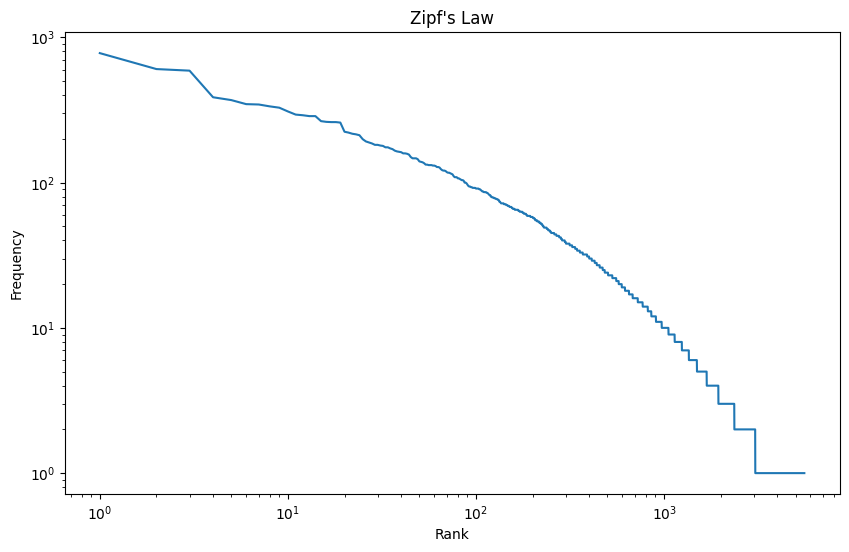

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.loglog(pandas_df["rank"], pandas_df["count"])
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.title("Zipf's Law")
plt.show()